In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
S_t = 50
Save_t = 50
K = 40
r = 0.3
q = 0.1
Sigma = 0.4
t = 0.1
T = 0.5
n_crr = 100
M = 50

In [3]:
#預先算好這些共用參數
delta_t = (T - t)/n_crr
u = np.exp(Sigma * np.sqrt(delta_t))
d = 1/u #算p比較方便，後面不會用到
p = (np.exp((r - q) * delta_t) - d) / (u - d)

In [4]:
def generate_panel(n):
    #d = [[0 for i in range(100)] for j in range(100)]
    d = np.zeros((n, n))
    data = np.array(d, dtype=object)
    for i in range(n):
        for j in range(n):
            data[i][j] = list()
    return data
#==================================================================================================================#
def count_data_manage(n, df):
    if n in df.keys():
        df[n] += 1
    else:
        df[n] = 1
#==================================================================================================================#
def Sequential_search_count(x, list_x, list_y):
    #start_t = time.time()
    count = -1
    for i in list_x:
        if i >= x:
            count += 1
        else:
            break
    if count == -1:
        c = list_y[0]
    elif count == len(list_y)-1:
        c = list_y[-1]
    else:
        wu = (list_x[count] - x) / (list_x[count] - list_x[count+1])
        c = wu * list_y[count+1] + (1-wu) * list_y[count]
    #end_t = time.time()
    #out_time = end_t - start_t
    return c #, count + 2, out_time #count是總共花幾次找到答案
#==================================================================================================================#
def Binomial_Arithmetic_call_count(M = 50, linearly = True):
    #建立資料panel
    panel = generate_panel(n_crr + 1)

    #第一步：算出panel上每個node的Amax, Amin
    for col in range(n_crr + 1):
        for row in range(col + 1):
            Amax = (Save_t * t * n_crr + S_t * ((u**(col-row) * (u**(-row)-u-1) + 1) / (1-u))) / (t * n_crr + (col+1))
            Amin = (Save_t * t * n_crr + S_t * ((u**(-row) * (u-u**(col-row+1)+1) - u) / (1-u))) / (t * n_crr + (col+1))
            panel[row][col].append([Amax])
            panel[row][col].append([Amin])

    #第二步：跟據M將每個node的Amax到Amin中間補上M-1個等差A(i,j,k)
    for col in range(n_crr+1):
        for row in range(col+1):
            #如果Amax=Amin就不要做
            if panel[row][col][0][0] == panel[row][col][-1][0]:
                pass
            else:
                for k in range(1, M):
                    if linearly == True:
                        ins = ((M-k)/M) * panel[row][col][0][0] + (k/M) * panel[row][col][-1][0]
                    else:
                        ins = np.exp(((M-k)/M) * np.log(panel[row][col][0][0]) + (k/M) * np.log(panel[row][col][-1][0]))
                    panel[row][col].insert(k, [ins])

    #第三步：將最後一期算出payoff
    for row in range(n_crr + 1):
        for i in panel[row][-1]:
            call_price = max(i[0]-K,0)
            i.append(call_price)
    
    #建立用來紀錄花幾次找到答案的字典
    count_dict = {}
    
    #第四步：backward induction，對每個node中每個A(i,j,k)分別計算call price
    for col in range(n_crr - 1, -1, -1):
        for row in range(col+1):
            for i in range(len(panel[row][col])):
                Au = (panel[row][col][i][0] * (t * n_crr + (col+1)) + S_t * u **(col-2*row+1)) / (t * n_crr + (col+1) + 1)
                Ad = (panel[row][col][i][0] * (t * n_crr + (col+1)) + S_t * u **(col-2*row-1)) / (t * n_crr + (col+1) + 1)

                #用歐式選擇權做代表
                #用這個函數一定要是遞增的
                #u_call_price = np.interp(Au, [j[0] for j in panel[row][col+1]][::-1], [j[1] for j in panel[row][col+1]][::-1])
                #d_call_price = np.interp(Ad, [k[0] for k in panel[row+1][col+1]][::-1], [k[1] for k in panel[row+1][col+1]][::-1])
                #自寫函式，應對本例可是遞減的
                u_call_price = Sequential_search_count(Au, [j[0] for j in panel[row][col+1]], [j[1] for j in panel[row][col+1]])
                d_call_price = Sequential_search_count(Ad, [k[0] for k in panel[row+1][col+1]], [k[1] for k in panel[row+1][col+1]])
                call_price = np.exp(-r * delta_t) * (p * u_call_price + (1-p) * d_call_price)
                panel[row][col][i].append(call_price)
                
                #前面都照做，到最後才區分為最上面一條＆最下面一條以及其他，若非最上或最下，每個node會有M+1個點
                #如果是最上或最下，因為不是最大就是最小，加入會扭曲結果，所以選擇不紀錄
#                if len(panel[row][col]) == 2:
#                    continue
#                #如果不是最上或最下，除了最後一個column，每個node有M+1個點，每個點會貢獻兩筆資料
#                else:
#                    count_data_manage(u_count+1, count_dict) #由於函式裡面是從-1開始，這邊要加1才代表真正的次數
#                    count_data_manage(d_count+1, count_dict)
                
    return panel[0][0][0][-1] #, count_dict

In [5]:
convergence = pd.DataFrame(index = range(50, 550, 50), columns = ['Linearly', 'Logarithmically'])

In [6]:
for i in convergence.index:
    eur_linear_price = Binomial_Arithmetic_call_count(i, True)
    convergence.loc[i, "Linearly"] = eur_linear_price
    print(i, " Linear Done")
    eur_logarithmically_price  = Binomial_Arithmetic_call_count(i, False)
    convergence.loc[i, "Logarithmically"] = eur_logarithmically_price
    print(i, " Logarithmical Done")

50  Linear Done
50  Logarithmical Done
100  Linear Done
100  Logarithmical Done
150  Linear Done
150  Logarithmical Done
200  Linear Done
200  Logarithmical Done
250  Linear Done
250  Logarithmical Done
300  Linear Done
300  Logarithmical Done
350  Linear Done
350  Logarithmical Done
400  Linear Done
400  Logarithmical Done
450  Linear Done
450  Logarithmical Done
500  Linear Done
500  Logarithmical Done


In [7]:
convergence

,Linearly,Logarithmically
50,10.5988,10.5907
100,10.5733,10.5713
150,10.5702,10.57
200,10.5695,10.5691
250,10.569,10.5688
300,10.5687,10.5686
350,10.5686,10.5685
400,10.5685,10.5684
450,10.5684,10.5684
500,10.5684,10.5683


Text(0.5, 1.0, 'Linearly vs. Logarithmically Convergence Rates')

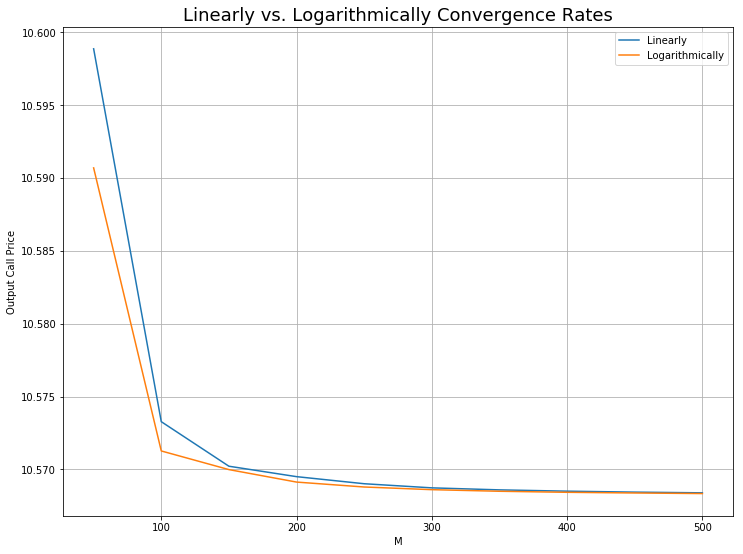

In [8]:
convergence.plot(figsize=(12,9),grid=True)
plt.xlabel('M')
plt.ylabel('Output Call Price')
plt.title('Linearly vs. Logarithmically Convergence Rates', size = 18)